## Initialization

## Load Data

In [21]:
pip install opencv-python


     |████████████████████████████████| 61.7 MB 77.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [22]:
!pip install opencv-python


In [15]:
import pandas as pd
import numpy as np
import os, sys
from PIL import Image

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
faces =  pd.read_csv('/datasets/faces/labels.csv')


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

In [4]:
# shape
faces.shape

(7591, 2)

In [5]:
# top 5
faces.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [6]:
# duplicates?
faces.duplicated().sum()

0

In [7]:
# 5 point summary
faces.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [8]:
# missing?
faces.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [9]:
# missing?
faces.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [10]:
# 5 point summary
faces.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [ ]:
from PIL import Image
import os, sys
import numpy as np

In [16]:
def plot_images(df, path, num=10, is_generator=False, img_datagen=None):
    """
    Plot a series of images
    """
    plt.figure(figsize=(10, 10))
    if not is_generator:
        sample_faces = df['file_name'].sample(n=num)
    else:
        sample_faces, _ = img_datagen
        sample_faces = sample_faces[:num]
    for idx, file in enumerate(sample_faces):
        # with open(os.path.join(path, file), 'rb') as f:
        plt.subplot(2, 5, idx+1)
        if not is_generator:
            img = Image.open(os.path.join(path, file))
            plt.imshow(np.array(img, dtype=np.uint8))
        else:
            img = file
            plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        # plt.xlabel(f'{file}')

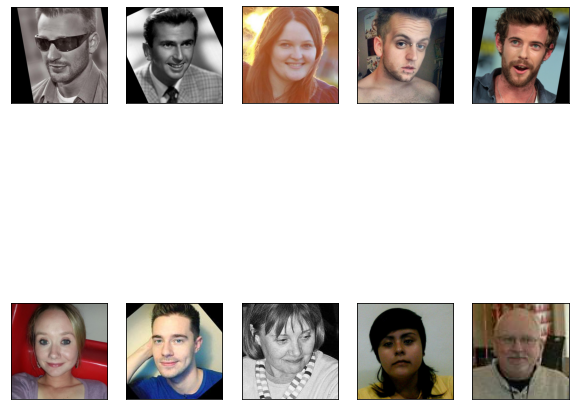

In [17]:
img_dir = '/datasets/faces/final_files/'
plot_images(faces, img_dir)

## EDA

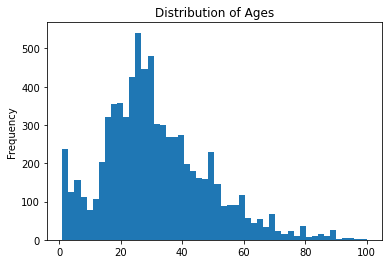

In [18]:
faces['real_age'].plot(kind='hist', title='Distribution of Ages', bins=50)
plt.show()


### Findings

The face capture different race and vary ages. Some pictures have show to be people of the age under 10 and senior citizen. 
The pictures collection are crop and doesnt show full lenght. Picture have object in the background and isnt the lighting for some of the photos.

In [19]:
datagen = ImageDataGenerator(rescale=1/255.,
                  horizontal_flip=True,
                  width_shift_range=.2,
                  zoom_range=0.2)
img_datagen = datagen.flow_from_dataframe(faces, 
                            x_col='file_name',
                            y_col='real_age',
                            directory=img_dir,
                            batch_size=32,
                            target_size=(150, 150),
                            class_mode='raw'
                           )
len(img_datagen)

Found 7591 validated image filenames.


238

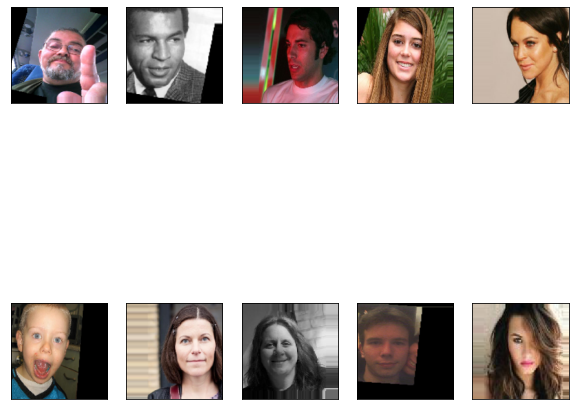

In [20]:
plot_images(faces, img_dir, is_generator=True, img_datagen=next(img_datagen))

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [26]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    df = pd.read_csv(os.path.join(path, 'labels.csv'))
    img_dir = os.path.join(path, 'final_files/')
    # place your code here
    train_gen = ImageDataGenerator(
                            validation_split=0.2,
                            rescale=1/255.,
                            horizontal_flip=True,
                            width_shift_range=.2,
                            # zoom_range=0.2,
    )
    train_gen_flow = train_gen.flow_from_dataframe(
                            df,
                            directory=img_dir,
                            x_col='file_name',
                            y_col='real_age',
                            target_size=(150, 150),
                            batch_size=16,
                            class_mode='raw',
                            subset='training',
                            seed=42,
                            )

    return train_gen_flow

In [27]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    df = pd.read_csv(os.path.join(path, 'labels.csv'))
    img_dir = os.path.join(path, 'final_files/')
    # place your code here
    test_gen = ImageDataGenerator(
                            validation_split=0.2,
                            rescale=1/255.,
    )
    test_gen_flow = test_gen.flow_from_dataframe(
                            df,
                            directory=img_dir,
                            x_col='file_name',
                            y_col='real_age',
                            target_size=(150, 150),
                            batch_size=16,
                            class_mode='raw',
                            subset='validation',
                            seed=42,
                            )

    return test_gen_flow

In [28]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    # model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=1, activation='relu'))
    optimizer = Adam(lr=0.00002)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model

In [29]:
def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True,
    )

    return model

### Prepare the Script to Run on the GPU Platform

In [ ]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd
import os
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

Train for 380 steps, validate for 95 steps

Epoch 1/5
380/380 - 78s - loss: 433.5224 - mae: 15.7080 - val_loss: 538.7270 - val_mae: 18.0530

Epoch 2/5
380/380 - 63s - loss: 110.1648 - mae: 7.9758 - val_loss: 166.7043 - val_mae: 9.5266
Epoch 3/5

380/380 - 62s - loss: 79.6256 - mae: 6.8682 - val_loss: 98.8871 - val_mae: 7.4128
Epoch 4/5

380/380 - 63s - loss: 62.2688 - mae: 6.0836 - val_loss: 92.1385 - val_mae: 7.3224
Epoch 5/5

380/380 - 62s - loss: 50.4715 - mae: 5.5138 - val_loss: 94.9900 - val_mae: 7.1193
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
95/95 - 7s - loss: 94.9900 - mae: 7.1193
Test MAE: 7.1193

## Conclusions

1) The initial model with a batch_size=32 and learning_rate=0.01 got a MAE of around 18 years.

2) After keeping everything the same and lowering the learning_rate=0.00002, the MAE got worse, it decreased to 9 years.

3) After removing the zooming operation, and reducing the batch_size=16, and removing the Dense layer of 128 neurons, and training for 5 epochs, we got an MAE of 7.1 years.

4) This can be further improved by adding dropout, and increasing the training time.